### Processing Data

In [1]:
import json
from Game import ChessGame
import os
from tqdm import tqdm

# Processing data
data = json.loads(open("PGNs/data.json", "r").read())
NUM_GAMES = 4000

if not os.path.exists("PGNs/data_processed.json"):
    fens = data["fens"][:NUM_GAMES]
    moves_till_now = data["moves"][:NUM_GAMES]
    legal_moves_lst = []
    best_move_lst = []
    current_position_score_lst = []
    best_move_score_lst = []

    game = ChessGame()
    for fen in tqdm(fens):
        game.set_board_to_fen(fen)
        best_move = game.get_best_move()
        legal_moves = [game.get_board().san(move) for move in game.get_board().legal_moves]
        current_position_score = game.get_score()
        game.play_move(best_move, san=True)
        best_move_score = game.get_score()

        # Append to lists
        legal_moves_lst.append(legal_moves)
        best_move_lst.append(best_move)
        current_position_score_lst.append(current_position_score)
        best_move_score_lst.append(best_move_score)

    # Closing game
    game.close()

    data["fens"] = fens
    data["moves"] = moves_till_now
    data["legal_moves"] = legal_moves_lst
    data["best_move"] = best_move_lst
    data["current_position_score"] = current_position_score_lst
    data["best_move_score"] = best_move_score_lst

    # Save data
    with open("PGNs/data_processed.json", "w") as f:
        f.write(json.dumps(data, indent=4))

# Adding Moves to Score
data = json.loads(open("PGNs/data_processed.json", "r").read())
# if "move_to_score" not in data:
#     game = ChessGame()
#     move_to_score_lst = []
#     for i in tqdm(range(NUM_GAMES)):
#         game.set_board_to_fen(data["fens"][i])
#         move_to_score = {}
#         legal_moves = data["legal_moves"][i]
#         for move in legal_moves:
#             game.play_move(move, san=True)
#             move_to_score[move] = game.get_score()
#             game.get_board().pop()
#         move_to_score_lst.append(move_to_score)
#     game.close()

#     # Save data
#     with open("PGNs/data_processed.json", "w") as f:
#         f.write(json.dumps(data, indent=4))

### Understanding Scoring

Positive --> White Winning
Negative --> Black Winning
Zero --> Draw

Problem: Best move doesn't have the hight or lowest score among all the legal moves...

In [2]:
# game = ChessGame(data["fens"][0])
# legal_moves = [game.get_board().san(move) for move in game.get_board().legal_moves]
# best_move = game.get_best_move()
# print(f"Game Position: {game.get_board().fen()}")
# for move in legal_moves:
#     print("### BEST MOVE ###") if move == best_move else None
#     game.play_move(move, san=True)
#     print(f"Playing move: {move}, Score: {game.get_score()}")
#     game.get_board().pop()
# game.close()

### Setting up Scorer LLM

In [3]:
from langchain_community.llms import Ollama
from requests import ReadTimeout

ollama = Ollama(model="gemma:2b", temperature=0, num_gpu = 40, timeout=60)

question_template = """Q: Given the moves played till now, and current Chess Position as a fen string, return the next best move in SAN format.
Chess Position as FEN: {fen}
Moves played till now: {moves}
"""

def chat(message):
    temp = ollama.timeout
    while True:
        try:
            res = ollama.invoke(message)
            return res
        except ReadTimeout:
            if ollama.timeout > 120:
                print(f"Inference lasted for {ollama.timeout} seconds. Stopping now.")
                break
            ollama.timeout *= 2
            print(f"### ReadTimeout. Trying again with Timeout: {ollama.timeout} seconds ###")
        except Exception as e:
            print(f"### {e} ###")
            break
    ollama.timeout = temp

def score(data, instruction, show_progress=False):
    """Checks how well a prompt does in helping the llm predict the next best move."""
    if show_progress:
        iterable_obj = tqdm(range(len(data["fens"])))
    else:
        iterable_obj = range(len(data["fens"]))

    score = 0
    qa_template = question_template + "A: {prompt}\n"

    for i in iterable_obj:
        fen = data["fens"][i]
        moves = data["moves"][i]
        best_move = data["best_move"][i]
        # legal_moves = data["legal_moves"][i]
        
        res = chat(qa_template.format(fen=fen, moves=moves, prompt=instruction))
        score += best_move in res

    return round(score / len(data["fens"]) * 100, 2)

### Optimizer LLM

In [4]:
import google.generativeai as genai

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
gemini = genai.GenerativeModel(
    "gemini-pro",
    generation_config=genai.GenerationConfig(temperature=1, max_output_tokens=2048),
)


def optimize(instruction_score_pairs):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    q1, q2, q3 = (
        question_template.format(fen=data["fens"][NUM_GAMES-1], moves=data["moves"][NUM_GAMES-1]),
        question_template.format(fen=data["fens"][NUM_GAMES-2], moves=data["moves"][NUM_GAMES-2]),
        question_template.format(fen=data["fens"][NUM_GAMES-3], moves=data["moves"][NUM_GAMES-3]),
    )
    a1, a2, a3 = (
        data["best_move"][NUM_GAMES-1],
        data["best_move"][NUM_GAMES-2],
        data["best_move"][NUM_GAMES-3],
    )
    # response = gemini.generate_content(
    #     prompt.format(pairs_str=pairs_str, q1=q1, q2=q2, q3=q3, a1=a1, a2=a2, a3=a3),
    # ).text
    response = gemini.generate_content(prompt.format(pairs_str=pairs_str, q1=q1, q2=q2, q3=q3, a1=a1, a2=a2, a3=a3)).candidates[0].content.parts[0].text
    return response

### OPRO

In [5]:
# Sample 3.5% of the training set
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
TRAIN_DATA_SIZE = 30
TEST_DATA_SIZE = 200
data = json.loads(open("PGNs/data_processed.json", "r").read())

# Train test spit
train_data = {
    "fens": data["fens"][:TRAIN_DATA_SIZE],
    "moves": data["moves"][:TRAIN_DATA_SIZE],
    "legal_moves": data["legal_moves"][:TRAIN_DATA_SIZE],
    "best_move": data["best_move"][:TRAIN_DATA_SIZE],
    "current_position_score": data["current_position_score"][:TRAIN_DATA_SIZE],
    "best_move_score": data["best_move_score"][:TRAIN_DATA_SIZE],
}

test_data = {
    "fens": data["fens"][TRAIN_DATA_SIZE:TRAIN_DATA_SIZE+TEST_DATA_SIZE],
    "moves": data["moves"][TRAIN_DATA_SIZE:TRAIN_DATA_SIZE+TEST_DATA_SIZE],
    "legal_moves": data["legal_moves"][TRAIN_DATA_SIZE:TRAIN_DATA_SIZE+TEST_DATA_SIZE],
    "best_move": data["best_move"][TRAIN_DATA_SIZE:TRAIN_DATA_SIZE+TEST_DATA_SIZE],
    "current_position_score": data["current_position_score"][TRAIN_DATA_SIZE:TRAIN_DATA_SIZE+TEST_DATA_SIZE],
    "best_move_score": data["best_move_score"][TRAIN_DATA_SIZE:TRAIN_DATA_SIZE+TEST_DATA_SIZE],
}

# loading saved data
if os.path.exists("instruction_scores.json"):
    with open("instruction_scores.json", "r") as f:
        opro_results = json.load(f)
    starting_step = len(opro_results) + 1
    ins_score_pairs = opro_results[str(len(opro_results))]
else:
    ins_lst = [
        "Let's think step by step.",
        "Solve.",
        "What should our next step be?",
        "Let’s think about this logically",
        "Take a deep breath and think through this.",
        "Break this down",
        "Let’s solve this problem by splitting it into steps",
    ]
    ins_score_pairs = {ins:score(train_data, ins) for ins in tqdm(ins_lst)}
    starting_step = 1
    opro_results = {starting_step: ins_score_pairs}
    with open("instruction_scores.json", "w") as f:
        json.dump(opro_results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 0
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            print("Optimizing instructions...")
            instructions = [optimize(ins_score_pairs) for _ in tqdm(range(INS_PER_STEP))]
            
            # Scoring the new instructions
            print("Scoring instructions...")
            new_ins_score_pairs = {ins: score(train_data, ins) for ins in tqdm(instructions)}
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(sorted(combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True)[:MAX_INS_SCORE_PAIRS])

            # Saving data
            opro_results[i] = ins_score_pairs
            with open("instruction_scores.json", "w") as f:
                json.dump(opro_results, f)
            
            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

### Plotting OPRO Results

Text(0.5, 1.0, 'Step to Accuracy')

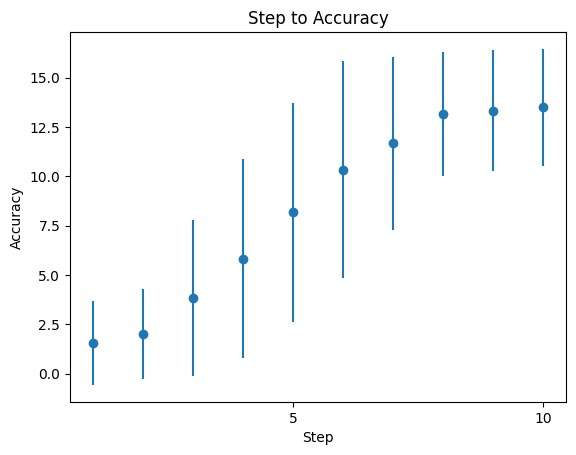

In [6]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open("instruction_scores.json") as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {step: (statistics.mean(opro_results[step].values()), statistics.stdev(opro_results[step].values())) for step in opro_results}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(step_to_accuracy.keys(), [accuracy[0] for accuracy in step_to_accuracy.values()], yerr=[accuracy[1] for accuracy in step_to_accuracy.values()], fmt='o')
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax.set_title('Step to Accuracy')

In [7]:
opro_results[str(len(opro_results))]

{'Break down the complex into simpler components.': 16.67,
 'Break down each step, identify its objective, and formulate a strategy to execute it.': 16.67,
 'Break down the complex challenge into smaller, more manageable steps. By analyzing the problem logically and identifying the underlying patterns, you can develop a clear plan to achieve your objective.': 16.67,
 'Break down the puzzle into smaller pieces, examine each individually, and assemble the solution by combining the parts.': 16.67,
 'Break down the complex task into smaller, manageable steps. Identify the objective of each step and devise a strategy to execute it logically.': 16.67,
 'Break the problem down into manageable parts by identifying the key elements and understanding their interrelationships.': 16.67,
 'Break down the intricate challenge into smaller, manageable components. Identify the objective of each step and formulate a methodical plan to execute them strategically.': 16.67,
 'Break down the multifaceted en

In [8]:
best_instruction = max(opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get)
print("No instruction: ", score(test_data, "", show_progress=True))
print(f"With best instruction ({best_instruction}): ", score(test_data, best_instruction, show_progress=True))

100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


No instruction:  2.5


100%|██████████| 200/200 [19:24<00:00,  5.82s/it]

With best instruction (Break down the complex into simpler components.):  14.5
